In [1]:
import galprime as gp

from photutils import background, segmentation

from astropy.convolution import convolve, Tophat2DKernel, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats

from scipy import ndimage

import numpy as np


40


/home/hsouch/GalPRIME/galprime/plotting/general_plots.py:31: RuntimeWarning: invalid value encountered in log10
  cutout = np.log10(cutout)


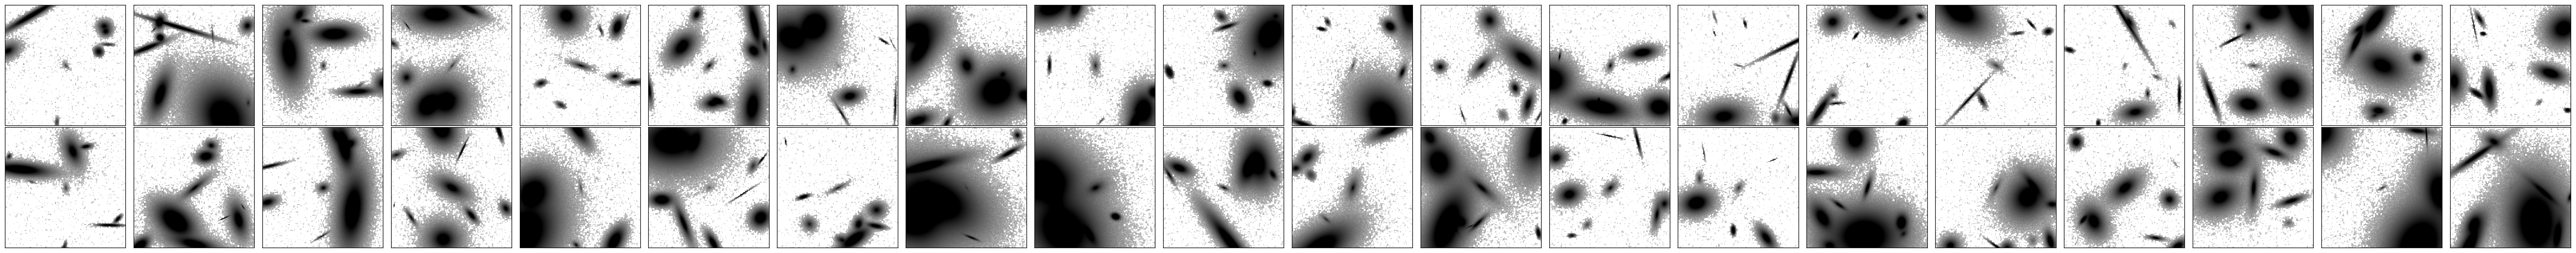

In [4]:
models = gp.gen_sersic_models(n_models=40, width=151)
noise_added_models = gp.add_gaussian_noise(models, std=0.05)
sersic_objects = gp.add_sersic_objects(noise_added_models, min_r=40)

gp.plotting.show_cutouts(sersic_objects, ncols=20, nrows=2, vmin=-2, vmax=1, method='log')



In [5]:
def make_source_mask(data, nsigma, npixels, mask=None, filter_fwhm=None,
                     filter_size=3, kernel=None, sigclip_sigma=3.0,
                     sigclip_iters=5, dilate_size=11):
    

    threshold = segmentation.detect_threshold(data, nsigma, background=None, error=None,
                                 mask=mask, sigclip_sigma=sigclip_sigma,
                                 sigclip_iters=sigclip_iters)

    if kernel is None and filter_fwhm is not None:
        kernel_sigma = filter_fwhm * gaussian_fwhm_to_sigma
        kernel = Gaussian2DKernel(kernel_sigma, x_size=filter_size,
                                  y_size=filter_size)
    if kernel is not None:
        kernel.normalize()

    segm = segmentation.detect_sources(data, threshold, npixels, kernel=kernel)
    if segm is None:
        return np.zeros(data.shape, dtype=bool)

    selem = np.ones((dilate_size, dilate_size))
    return ndimage.binary_dilation(segm.data.astype(bool), selem)


def dilate_mask(mask, tophat_size):
    """
    Dilates a binary mask using a circular structuring element.

    Parameters:
    mask (ndarray): Binary mask to be dilated.
    tophat_size (float): Size of the circular structuring element.

    Returns:
    ndarray: Dilated mask.
    """
    area = np.pi * tophat_size ** 2.
    kernel = Tophat2DKernel(tophat_size)
    dilated_mask = convolve(mask, kernel) >= 1. / area
    return dilated_mask


def estimate_background_sigclip(data, config=None, nsigma=2, npixels=3, dilate_size=7):
    """
    Estimate the background statistics of an input data array using sigma clipping.

    Parameters:
    - data: numpy.ndarray
        Input data array.
    - config: dict, optional
        Configuration dictionary containing masking parameters. If provided, the values
        from the configuration will be used for nsigma and npixels. Default is None.
    - nsigma: float, optional
        Number of standard deviations to use for sigma clipping. Ignored if config is provided.
        Default is 2.
    - npixels: int, optional
        Number of connected pixels required for a source mask. Ignored if config is provided.
        Default is 3.
    - dilate_size: int, optional
        Size of the structuring element used for dilating the source mask. Default is 7.

    Returns:
    - bg_mean: float
        Mean background value.
    - bg_median: float
        Median background value.
    - bg_std: float
        Standard deviation of the background values.
    """
    nsigma is float(config["MASKING"]["NSIGMA"]) if config is not None else nsigma
    npixels is int(config["MASKING"]["NPIX"]) if config is not None else npixels

    bg_mask = make_source_mask(data, nsigma=nsigma, npixels=npixels, dilate_size=dilate_size)

    bg_mean, bg_median, bg_std = sigma_clipped_stats(data, sigma=3.0, mask=bg_mask)

    return bg_mean, bg_median, bg_std



In [ ]:
def subtract_background(data, config=None):
    pass